# This experiment was done to see how model Model-2 936K behves with kernel_initializer="he_uniform" (It does not converge faster)

- 4 Denseblocks with layer [14,14,14,14], growth rate= 12, compression = 0.5, dropout = 0.2 has achived 92.10 (previous test)

- It is seen that Model-2 936K params with kernel_initializer="he_uniform"  with Adam() does not result in faster covergence than the model with out intilization



In [4]:
# https://keras.io/
#!pip install -q keras
import keras

In [5]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [6]:
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
from sklearn import cross_validation

In [7]:
import matplotlib.pyplot as plt
import time, pickle
%matplotlib inline

In [8]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [9]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
#l = 40
#num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [10]:
do_sub_sampling_of_input = False
do_data_augmentation = True
do_data_append       = False   #2X

In [11]:
# Load CIFAR10 Data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]



In [12]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [13]:
y_train[0], img_height, img_width, channel

(array([6], dtype=uint8), 32, 32, 3)

In [14]:
def draw_img(i, x_train, y_train, class_name):
    im = x_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (int(c), class_name[int(c)]))
    plt.axis('on')

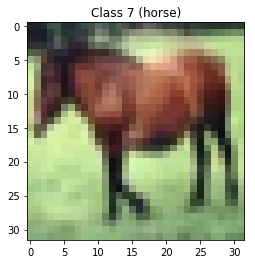

In [15]:
draw_img(7, x_train, y_train, class_name)

### Helper functions to dispaly and analyze data

These helper functions

plot_confusion_matrix(): helps us to plot the confusion matrix. 
It is taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html. 
The same page has some sample examples on how to use this function 
cm: Confusion matrix calcualted using confusion_matrix() from sklearn.metrics <br//> classes: a list of labels for the classes we are plotting
normalize=False: True means we will plot nomalized values 
title='Confusion matrix': set the tiltle of the plot 
cmap : leave it as it is 
Example Usage:plot_confusion_matrix(cm, classes=Facial_Expressions, normalize=True, title='Test Data - Using Simple Average Ensembling ')

plot_histogram(): helps to plot the histogram of a list 
lst_data: the list whose histogtam we want to plot , 
class_labels: a list of labels for the classes we are plotting 
ylabel='None': set the y label of the plot, x label is always frequency 
title='None': set the tiltle of the plot -lst_data, class_labels, ylabel='None', title='None'

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm) #to print in text if needed

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_histogram(lst_data, class_labels, ylabel='None', title='None'):
    data = pd.Series(lst_data)
    distribution = data.value_counts(sort=False)
    y_pos = np.arange(len(class_labels))
    
    plt.bar(y_pos, distribution, align='center', alpha=0.8)
    plt.xticks(y_pos, class_labels)
    plt.ylabel(ylabel)
    plt.title(title)

In [17]:
y_classes = ['airplane', 'automobile', 'bird','cat', 'deer','dog','frog','horse','ship','truck']

In [18]:
y_train.shape

(50000, 1)

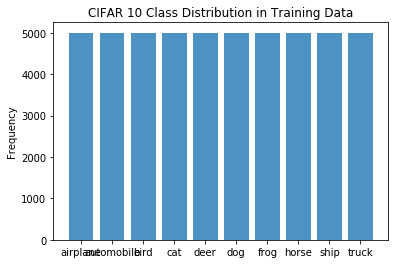

In [19]:
plot_histogram(list(y_train), y_classes, ylabel='Frequency',title='CIFAR 10 Class Distribution in Training Data')

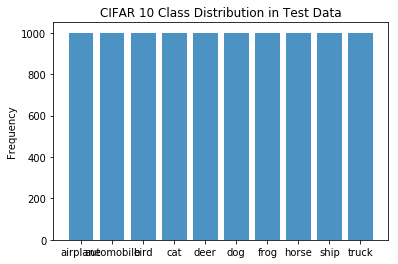

In [20]:
plot_histogram(list(y_test), y_classes, ylabel='Frequency',title='CIFAR 10 Class Distribution in Test Data')

In [21]:
# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:

x_train[0][0:32][0:32][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [23]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [24]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

mean  = np.mean(x_train, axis=(0, 1, 2), keepdims=True).astype('float32')
std   = np.std(x_train, axis=(0, 1, 2), keepdims=True).astype('float32')

mean1  = np.mean(x_test, axis=(0, 1, 2), keepdims=True).astype('float32')
std1   = np.std(x_test, axis=(0, 1, 2), keepdims=True).astype('float32')


print("Channel Mean : ", mean)
print("Channel Std : ", std)
print("Channel Mean1 : ", mean1)
print("Channel Std1 : ", std1)



x_train = (x_train - mean) / (std)
x_test  = (x_test - mean1) / (std1)

Channel Mean :  [[[[125.3069  122.95015 113.866  ]]]]
Channel Std :  [[[[62.99325  62.088604 66.70501 ]]]]
Channel Mean1 :  [[[[126.02428 123.70843 114.85442]]]]
Channel Std1 :  [[[[62.896416 61.937508 66.70607 ]]]]


In [25]:
#x_train = (x_train - 127.5)/255.0
#x_test  = (x_test  - 127.5)/255.0

In [26]:
x_train[0]

array([[[-1.0526032e+00, -9.8166406e-01, -7.6255137e-01],
        [-1.3065987e+00, -1.2393603e+00, -1.0323962e+00],
        [-1.1954757e+00, -1.2071482e+00, -1.0623789e+00],
        ...,
        [ 5.1899368e-01,  1.4575703e-01, -8.7939382e-02],
        [ 4.2374539e-01,  3.3014923e-02, -1.7788765e-01],
        [ 3.6024651e-01,  1.6908908e-02, -1.6289628e-01]],

       [[-1.7352160e+00, -1.6581167e+00, -1.4071807e+00],
        [-1.9892114e+00, -1.9802370e+00, -1.7070082e+00],
        [-1.7034665e+00, -1.8513888e+00, -1.7070082e+00],
        ...,
        [-3.6621384e-02, -5.6290764e-01, -8.8248241e-01],
        [-1.0012025e-01, -6.4343774e-01, -9.5743930e-01],
        [-5.2496098e-02, -5.7901365e-01, -8.5249966e-01]],

       [[-1.5923436e+00, -1.5936927e+00, -1.3921893e+00],
        [-1.7352160e+00, -1.8674948e+00, -1.7070082e+00],
        [-1.2113504e+00, -1.5453745e+00, -1.5870771e+00],
        ...,
        [-1.1599497e-01, -6.2733167e-01, -9.5743930e-01],
        [-8.4245533e-02, -6.2

In [27]:
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [28]:
print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [29]:
if do_sub_sampling_of_input:
    x_, x_train, x_, y_train    = cross_validation.train_test_split(x_train, y_train, test_size=0.25, random_state=0)
    x_, x_test,  y_, y_test    = cross_validation.train_test_split(x_test, y_test, test_size=0.25, random_state=0)
    print("After SubSampling")
    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)

In [30]:
import numpy as np

if do_data_append :
    print("Doing Data Appending")
    x_train = np.append(x_train, x_train,axis=0)
    y_train = np.append(y_train, y_train,axis=0)
#print(np.append(x_train, x_train,axis=0).shape)
#print(np.append(y_train, y_train,axis=0).shape)


In [31]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)


# Data Augmentation

In [32]:
keras.utils.Sequence
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [33]:
from keras.layers import SeparableConv2D
from keras.regularizers import l2

## Construction densenet -BC

In [36]:
# Dense Block
def add_denseblock1(input, growth_rate, dropout_rate = 0.2, l = 0, weight_decay= 0.0001):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        #Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #Conv2D_1_1 = Conv2D(int(num_filter*4*compression), (1,1), use_bias=False ,padding='same')(relu)
        Conv2D_1_1 = Conv2D(int(growth_rate*4), (1,1), use_bias=False ,padding='same',
                            kernel_initializer="he_uniform", kernel_regularizer=l2(weight_decay))(relu)
        if dropout_rate>0:
            Conv2D_1_1 = Dropout(dropout_rate)(Conv2D_1_1)
        BatchNorm_1_1 = BatchNormalization()(Conv2D_1_1)
        relu_1_1 = Activation('relu')(BatchNorm_1_1)
        
        Conv2D_3_3 = Conv2D(int(growth_rate), (3,3), use_bias=False ,padding='same',
                            kernel_initializer="he_uniform", kernel_regularizer=l2(weight_decay))(relu_1_1)
        #Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu_1_1)
        if dropout_rate>0:
            Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [37]:
# Dense Block
def add_denseblock(input, growth_rate, dropout_rate = 0.2, l = 0, weight_decay= 0.0001):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        #Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #Conv2D_1_1 = Conv2D(int(num_filter*4*compression), (1,1), use_bias=False ,padding='same')(relu)
        Conv2D_1_1 = Conv2D(int(growth_rate*4), (1,1), use_bias=False ,padding='same',
                            kernel_initializer="he_uniform")(relu)
        if dropout_rate>0:
            Conv2D_1_1 = Dropout(dropout_rate)(Conv2D_1_1)
        BatchNorm_1_1 = BatchNormalization()(Conv2D_1_1)
        relu_1_1 = Activation('relu')(BatchNorm_1_1)
        
        Conv2D_3_3 = Conv2D(int(growth_rate), (3,3), use_bias=False ,padding='same',
                            kernel_initializer="he_uniform")(relu_1_1)
        #Conv2D_3_3 = SeparableConv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu_1_1)
        if dropout_rate>0:
            Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [38]:
def add_transition1(input, dropout_rate = 0.2, weight_decay= 0.0001):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    num_channels = int(input.shape[-1]) #assuming it is tensor
    Conv2D_BottleNeck = Conv2D(int(num_channels*compression), (1,1), use_bias=False ,padding='same', 
                               kernel_initializer="he_uniform", kernel_regularizer=l2(weight_decay))(relu)
    
    #Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [39]:
def add_transition(input, dropout_rate = 0.2, weight_decay= 0.0001):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    num_channels = int(input.shape[-1]) #assuming it is tensor
    Conv2D_BottleNeck = Conv2D(int(num_channels*compression), (1,1), use_bias=False ,padding='same', 
                               kernel_initializer="he_uniform")(relu)
    
    #Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [40]:
def output_layer1(input, weight_decay= 0.0001):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    #flat = Dropout(0.25)(flat)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(flat)
    
    return output

In [41]:
def output_layer(input, weight_decay= 0.0001):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    #flat = Dropout(0.25)(flat)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [42]:
#num_filter = 12
num_filter = growth_rate = 12

dropout_rate = 0.2
#compression = 0.751
compression = 0.5
l = 16
dense_l= [8, 16, 20, 12]
dense_l= [12, 12, 12, 12]
dense_l= [14, 14, 14, 14]

weight_decay = 0.0001

input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(2*num_filter, (3,3), use_bias=False ,padding='same',
                      kernel_initializer="he_uniform", kernel_regularizer=l2(weight_decay))(input)

First_Block = add_denseblock(First_Conv2D, growth_rate, dropout_rate, dense_l[0])
First_Transition = add_transition(First_Block, dropout_rate)

Second_Block = add_denseblock(First_Transition, growth_rate, dropout_rate, dense_l[1])
Second_Transition = add_transition(Second_Block, dropout_rate)

Third_Block = add_denseblock(Second_Transition, growth_rate, dropout_rate, dense_l[2])
Third_Transition = add_transition(Third_Block, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  growth_rate, dropout_rate, dense_l[3])
output = output_layer(Last_Block)



###  Printing and Verifying the Densenet-BC configuration

In [43]:
print(input.shape)
print(First_Conv2D.shape)
print(First_Block.shape, First_Block.shape[-1])
print(First_Transition.shape)

print(Second_Block.shape)
print(Second_Transition.shape)

print(Third_Block.shape)
print(Third_Transition.shape)

print(Last_Block.shape)

(?, 32, 32, 3)
(?, 32, 32, 24)
(?, 32, 32, 192) 192
(?, 16, 16, 96)
(?, 16, 16, 264)
(?, 8, 8, 132)
(?, 8, 8, 300)
(?, 4, 4, 150)
(?, 4, 4, 318)


In [44]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [45]:
learning_rate = 0.1
epochs = 90
decay = learning_rate/epochs
decay = 0.0001

sgd = keras.optimizers.SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)

In [46]:
#batch_size = 64
#clr_triangular = CyclicLR(mode='triangular', base_lr = 0.1, max_lr = 0.2, step_size = (len(x_train)* 2 * 4)/batch_size)

In [71]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.Adam(),
              metrics=['accuracy'])

In [72]:
from keras.callbacks import LearningRateScheduler
import numpy
import math

In [73]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 30.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [74]:
# learning rate schedule
def step_decay1(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epoch_drop_01 = 40
    epoch_drop_02 = epoch_drop_01 + 40
    epoch_drop_03 = epoch_drop_02 + 40
    
    if (epoch < epoch_drop_01):
        lrate = initial_lrate
    elif (epoch < epoch_drop_02):
        lrate = initial_lrate * drop
    else:
        lrate = initial_lrate * drop * drop

    return lrate

In [75]:
def on_epoch_end(self, epoch, logs=None):
    print("epoch: ", epoch,"learning rate for", K.eval(self.model.optimizer.lr))

In [76]:
lrate = LearningRateScheduler(step_decay1)

In [77]:
from keras.callbacks import ReduceLROnPlateau

reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience= 4, min_delta=0.003, verbose=1, cooldown=0, min_lr=0.001)

In [78]:
from keras.callbacks import ModelCheckpoint

In [79]:
#from google.colab import files
#filepath = file_prefix + r".best.hdf5"
filepath = "DNST_CIFAR10_Conv_09_12-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)


In [80]:
# Save the trained weights in to .h5 format
#model.save_weights("densenet_tr_03-{epoch:02d}-{val_acc:.2f}.hdf5")
#print("Saved model to disk")

In [81]:
#from google.colab import files

#files.download('DNST_model.h5')

In [82]:
from keras import backend as K
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import LearningRateScheduler

In [83]:
class AdamTracker_0(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("start , epoch = ", epoch,", lr = ", K.eval(optimizer.lr),", decay = ",K.eval(optimizer.decay),)

In [84]:
class AdamTracker_1(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("end, epoch = ", epoch,", lr = ", K.eval(optimizer.lr),", decay = ",K.eval(optimizer.decay),)

In [85]:
adam_lr_tracker_1 = AdamTracker_1()
adam_lr_tracker_0 = AdamTracker_0()

In [86]:
class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLR: {:.6f}\n'.format(lr))
        print("epoch = ", epoch,", lr = ", K.eval(optimizer.lr), ", momentum = ",K.eval(optimizer.momentum),
              ", decay = ",K.eval(optimizer.decay), ", Nestrov = ",optimizer.nesterov)

In [87]:
sgd_lr_tracker = SGDLearningRateTracker()

In [88]:
callbacks_list = [checkpoint, reduce_on_plateau]

In [89]:
callbacks_list = [adam_lr_tracker_0, adam_lr_tracker_1]

In [90]:
#callbacks_list = [checkpoint, adam_lr_tracker_0, adam_lr_tracker_1, clr_triangular]

In [91]:
#callbacks_list = [checkpoint, sgd_lr_tracker]

In [92]:
from keras.models import load_model

#model = load_model('densenet_tr_03-46-0.71.hdf5')
#score = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [93]:
len(x_train)

50000

## Call the model with the datagen, augmentation

#### running  with same setting as Model2_Adam_test.ipynb.ipynb

In [94]:
batch_size = 64
epochs = 80

In [95]:
load_model_from_back = False

if load_model_from_back:
    model = load_model('----------------')
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [96]:
if do_data_augmentation:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        steps_per_epoch= (len(x_train)* 1.0)/batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list)
else:
    model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)    

Epoch 1/80
start , epoch =  0 , lr =  0.001 , decay =  0.0
782/781 [==============================] - 184s 235ms/step - loss: 1.5734 - acc: 0.4283 - val_loss: 1.3922 - val_acc: 0.5361
end, epoch =  0 , lr =  0.001 , decay =  0.0
Epoch 2/80
start , epoch =  1 , lr =  0.001 , decay =  0.0
782/781 [==============================] - 145s 186ms/step - loss: 1.1683 - acc: 0.5845 - val_loss: 1.1952 - val_acc: 0.6215
end, epoch =  1 , lr =  0.001 , decay =  0.0
Epoch 3/80
start , epoch =  2 , lr =  0.001 , decay =  0.0
782/781 [==============================] - 145s 186ms/step - loss: 0.9741 - acc: 0.6536 - val_loss: 1.2167 - val_acc: 0.6460
end, epoch =  2 , lr =  0.001 , decay =  0.0
Epoch 4/80
start , epoch =  3 , lr =  0.001 , decay =  0.0
782/781 [==============================] - 144s 184ms/step - loss: 0.8545 - acc: 0.6989 - val_loss: 0.9888 - val_acc: 0.7016
end, epoch =  3 , lr =  0.001 , decay =  0.0
Epoch 5/80
start , epoch =  4 , lr =  0.001 , decay =  0.0
782/781 [================

KeyboardInterrupt: 

### Stopped early as it does not seem to converge faster than normal Model-2 with 936K params